In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch
!pip install transformers
!pip install streamlit
# !pip install fiftyone
!pip install tqdm
!pip install Pillow
!pip install git+https://github.com/openai/CLIP.git
!pip install gradio
!pip install git+https://github.com/salaniz/pycocoevalcap.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2eug0jrk
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2eug0jrk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=7dd2e61529a3c36c300979da74bfd1b9e8dd9d6879d8730603319cbdfef99140
  Stored in directory: /tmp/pip-ephem-wheel-cache-dsy6amny/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Succ

## **Dataset**

In [3]:
import os
import requests
from zipfile import ZipFile
from pycocotools.coco import COCO
from tqdm import tqdm
from PIL import Image
from io import BytesIO

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Google drive path
COCO_DIR = '/content/drive/MyDrive/COCO_subset'
# Test path
test_zip_path = os.path.join(COCO_DIR, "test2017.zip")
os.makedirs(COCO_DIR, exist_ok=True)

# COCO annotations URL
COCO_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
TRAIN_IMAGES_URL = "http://images.cocodataset.org/zips/train2017.zip"
VAL_IMAGES_URL = "http://images.cocodataset.org/zips/val2017.zip"
TEST_IMAGES_URL = "http://images.cocodataset.org/zips/test2017.zip"
#images_dir = os.path.join(COCO_DIR, 'images')



# Download and extract annotations to Google Drive
def download_coco_annotations():
    print("Checking if annotations are already downloaded...")
    annotations_zip_path = os.path.join(COCO_DIR, "annotations_trainval2017.zip")
    annotations_extract_dir = os.path.join(COCO_DIR, "annotations")

    if not os.path.exists(os.path.join(annotations_extract_dir, 'captions_train2017.json')):
        if not os.path.exists(annotations_zip_path):
            # Download annotations if they don't exist
            print("Downloading COCO annotations...")
            response = requests.get(COCO_ANNOTATIONS_URL, stream=True)
            with open(annotations_zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

        # Extract the annotations zip
        print("Extracting COCO annotations...")
        with ZipFile(annotations_zip_path, 'r') as zip_ref:
            zip_ref.extractall(annotations_extract_dir)
        print("Annotations downloaded and extracted.")
    else:
        print("Annotations already exist. Skipping download.")

# Download and extract trainval images
def download_and_extract_images(images_url, save_dir, dataset_name):
    zip_path = os.path.join(COCO_DIR, f'{dataset_name}.zip')

    if not os.path.exists(save_dir):
        if not os.path.exists(zip_path):
            print(f"Downloading {dataset_name} images...")
            response = requests.get(images_url, stream=True)
            with open(zip_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)

        # Extract the images
        print(f"Extracting {dataset_name} images...")
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(save_dir)
        print(f"{dataset_name} images downloaded and extracted.")
    else:
        print(f"{dataset_name} images already exist. Skipping download.")

# Download a subset of COCO images (for training and validation datasets)
def download_coco_images(coco, save_dir, num_images=8000):
    if not os.path.exists(save_dir):
        # Get all image IDs
        all_image_ids = coco.getImgIds()

        # Select a random subset of image IDs
        import random
        subset_image_ids = random.sample(all_image_ids, num_images)
        print(f"Selected {len(subset_image_ids)} images for the subset.")

        # Directory to save images
        os.makedirs(save_dir, exist_ok=True)

        # Download each image in the subset
        for img_id in tqdm(subset_image_ids):
            img_info = coco.loadImgs(img_id)[0]
            download_image(img_info, save_dir)
        print(f"Downloaded {len(subset_image_ids)} images to {save_dir}.")
    else:
      print(f"{save_dir} already exists. Skipping download.")

# Download images
def download_image(img_info, save_dir):
    img_url = img_info['coco_url']
    img_filename = os.path.join(save_dir, img_info['file_name'])

    # Download the image only if it doesn't exist
    if not os.path.exists(img_filename):
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content))
        img.save(img_filename)

# Download the test dataset
def download_test_dataset(zip_path, images_url):
    if not os.path.exists(zip_path):
        print(f"Downloading COCO 2017 test dataset...")
        response = requests.get(images_url, stream=True)
        with open(zip_path, 'wb') as f:
            for chunk in tqdm(response.iter_content(chunk_size=8192)):
                f.write(chunk)
        print(f"Test dataset downloaded to {zip_path}")
    else:
        print(f"Test dataset already exists at {zip_path}. Skipping download.")

# Extract a subset of test images
def extract_test_subset(zip_path, extract_dir, num_files=100):
    # Open the zip file
    if not os.path.exists(zip_path):
        with ZipFile(zip_path, 'r') as zip_ref:
            # List all the files in the zip
            all_files = zip_ref.namelist()

            # Filter the JPG images
            image_files = [f for f in all_files if f.endswith('.jpg')]

            # Extract only the first `num_files` images
            for img_file in image_files[:num_files]:
                zip_ref.extract(img_file, extract_dir)
                print(f"Extracted {img_file}")

            print(f"Extracted {num_files} images to {extract_dir}")
    else:
        print(f"Test dataset zip file already exists at {zip_path}. Skipping extraction.")


# Run the process
download_coco_annotations()

# Directories for training, validation, and test images
train_images_dir = os.path.join(COCO_DIR, 'train2017')
val_images_dir = os.path.join(COCO_DIR, 'val2017')
test_images_dir = os.path.join(COCO_DIR, 'test2017')

# Download and extract training and validation images
download_and_extract_images(TRAIN_IMAGES_URL, train_images_dir, "train2017")
download_and_extract_images(VAL_IMAGES_URL, val_images_dir, "val2017")

# Get a subset of training and validation images
train_coco = COCO(os.path.join(COCO_DIR, "annotations/annotations", "captions_train2017.json"))
download_coco_images(train_coco, train_images_dir, num_images=1000)

val_coco = COCO(os.path.join(COCO_DIR, "annotations/annotations", "captions_val2017.json"))
download_coco_images(val_coco, val_images_dir, num_images=100)

# Download the test dataset if it doesn't exist
download_test_dataset(test_zip_path, TEST_IMAGES_URL)
# Download a subset of test images
extract_test_subset(test_zip_path, test_images_dir, num_files=50)

KeyboardInterrupt: 

In [ ]:
'''
import os

test_zip_path = os.path.join(COCO_DIR, 'test2017.zip')  # 현재 지정된 경로
print(f"ZIP 파일 경로: {test_zip_path}")
print(f"파일 존재 여부: {os.path.exists(test_zip_path)}")
'''

ZIP 파일 경로: /content/drive/MyDrive/COCO_subset/test2017.zip
파일 존재 여부: True


In [ ]:
'''
import shutil

# 파일 이동
src_path = os.path.join(COCO_DIR, 'test2017.zip')
dest_path = os.path.join(COCO_DIR, 'test2017.zip')

if os.path.exists(src_path):
    shutil.move(src_path, dest_path)
    print(f"Moved {src_path} to {dest_path}")
else:
    print("파일이 존재하지 않습니다.")
'''

Moved /content/drive/MyDrive/COCO_subset/test2017.zip to /content/drive/MyDrive/COCO_subset/test2017.zip


In [ ]:
import os
from zipfile import ZipFile

# Extract a subset of test images
def extract_test_subset(zip_path, extract_dir, num_files):
    # Check if the zip file exists
    if not os.path.exists(zip_path):
        print(f"Error: Zip file '{zip_path}' not found.")
        return

    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_dir, exist_ok=True)

    # Open the zip file
    with ZipFile(zip_path, 'r') as zip_ref:
        # List all the files in the zip
        all_files = zip_ref.namelist()

        # Filter the JPG images
        image_files = [f for f in all_files if f.endswith('.jpg')]

        # Check if enough images exist
        if len(image_files) < num_files:
            print(f"Warning: Requested {num_files} files, but only {len(image_files)} available.")
            num_files = len(image_files)

        # Extract only the first `num_files` images
        for img_file in image_files[:num_files]:
            zip_ref.extract(img_file, extract_dir)
            print(f"Extracted {img_file}")

        print(f"Extracted {num_files} images to {extract_dir}")

# Paths
COCO_DIR = '/content/drive/MyDrive/COCO_subset'
zip_path = '/content/drive/MyDrive/COCO_subset/test2017.zip'
test_images_dir = os.path.join(COCO_DIR, 'test2017')

# Output information
print(f"ZIP 파일 경로: {zip_path}")
print(f"파일 존재 여부: {os.path.exists(zip_path)}")

# Run the extraction function
extract_test_subset(zip_path, test_images_dir, num_files=20)


ZIP 파일 경로: /content/drive/MyDrive/COCO_subset/test2017.zip
파일 존재 여부: True
Extracted test2017/000000259564.jpg
Extracted test2017/000000344475.jpg
Extracted test2017/000000139491.jpg
Extracted test2017/000000426648.jpg
Extracted test2017/000000563577.jpg
Extracted test2017/000000233616.jpg
Extracted test2017/000000026923.jpg
Extracted test2017/000000510196.jpg
Extracted test2017/000000523969.jpg
Extracted test2017/000000400725.jpg
Extracted test2017/000000166089.jpg
Extracted test2017/000000513941.jpg
Extracted test2017/000000355340.jpg
Extracted test2017/000000466315.jpg
Extracted test2017/000000359817.jpg
Extracted test2017/000000358375.jpg
Extracted test2017/000000438062.jpg
Extracted test2017/000000342419.jpg
Extracted test2017/000000155660.jpg
Extracted test2017/000000211454.jpg
Extracted 20 images to /content/drive/MyDrive/COCO_subset/test2017


In [ ]:
#colab 환경과 달리 google drive에 폴더가 나타나지 않아 추가한 코드
from google.colab import drive
drive.flush_and_unmount()  # Google Drive 강제 동기화 및 연결 해제
drive.mount('/content/drive')  # 다시 연결


Mounted at /content/drive


# **Dataloader**

In [ ]:

import torch
from torch.nn.utils.rnn import pad_sequence
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, CLIPProcessor, CLIPModel
from PIL import Image
from pycocotools.coco import COCO
import os
import gradio as gr
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

# 장치 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 경로
COCO_DIR = '/content/drive/MyDrive/COCO_subset'
#IMAGES_DIR = os.path.join(COCO_DIR, 'images')
TRAIN_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_train2017.json')
DETECTIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'instances_train2017.json')
VAL_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_val2017.json')

# 학습,검증 이미지 경로
TRAIN_IMAGES_DIR = os.path.join(COCO_DIR, 'train2017/train2017')
VAL_IMAGES_DIR = os.path.join(COCO_DIR, 'val2017/val2017')

# caption 파일 로드 함수
def load_coco_annotations():
    coco_train_captions = COCO(TRAIN_ANNOTATIONS_FILE)
    coco_val_captions = COCO(VAL_ANNOTATIONS_FILE)
    coco_detections = COCO(DETECTIONS_FILE)
    print('exiting loading annotations')
    return coco_train_captions, coco_val_captions, coco_detections

coco_train_captions, coco_val_captions, coco_detections = load_coco_annotations()

# 이미지 ID 가져오는 함수
def get_downloaded_image_ids(images_dir):
    print('getting image ids')
    return {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')} # 이미지 디렉토리에서 파일 이름을 가져와 .jpg확장자를 제거 후 리턴

# 각각 이미지 ID 제한
train_image_ids = get_downloaded_image_ids(TRAIN_IMAGES_DIR)
val_image_ids = get_downloaded_image_ids(VAL_IMAGES_DIR)

# 학습 데이터셋에서 1000개, 검증 데이터셋에서 100개의 랜덤하게 이미지 샘플링
#train_image_ids = random.sample(train_image_ids, min(2000, len(train_image_ids)))
#val_image_ids = random.sample(val_image_ids, min(200, len(val_image_ids)))
train_image_ids = random.sample(list(train_image_ids), min(1000, len(train_image_ids)))
val_image_ids = random.sample(list(val_image_ids), min(100, len(val_image_ids)))

# COCODataset 정의
class COCODataset(Dataset):
    def __init__(self, coco_captions, coco_detections, images_dir, clip_processor, gpt_tokenizer, available_image_ids,
                 max_length=50):
        print(f"Initializing COCODataset with {len(available_image_ids)} available images")
        self.coco_captions = coco_captions
        self.coco_detections = coco_detections
        self.images_dir = images_dir
        self.clip_processor = clip_processor
        self.gpt_tokenizer = gpt_tokenizer

        # 로컬에 존재하는 이미지 ID만 필터링
        self.image_ids = [img_id for img_id in coco_captions.getImgIds()
                          if str(img_id).zfill(12) in available_image_ids]

        self.max_length = max_length
        print(f"Filtered dataset to {len(self.image_ids)} images")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco_captions.loadImgs(img_id)[0]
        img_filename = os.path.join(self.images_dir, img_info['file_name'])

        # 이미지 로드
        try:
            image = Image.open(img_filename).convert("RGB")

            # 캡션 가져오기
            ann_ids = self.coco_captions.getAnnIds(imgIds=img_id)
            anns = self.coco_captions.loadAnns(ann_ids)
            caption = anns[0]['caption'] if anns else ""

            # 객체 감지 캡션 가져오기
            object_ann_ids = self.coco_detections.getAnnIds(imgIds=img_id, iscrowd=False)
            object_anns = self.coco_detections.loadAnns(object_ann_ids)
            objects = [self.coco_detections.loadCats(obj['category_id'])[0]['name'] for obj in object_anns]

            # CLIPProcessor로 이미지 전처리
            image_inputs = self.clip_processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)

            # GPT2Tokenizer로 캡션 전처리
            input_ids = self.gpt_tokenizer(caption, padding="max_length", truncation=True, max_length=self.max_length,
                                           return_tensors="pt")['input_ids'].squeeze(0)

            labels = input_ids.clone()  # 라벨은 input_ids

            return image_inputs, input_ids, labels, objects

        except Exception as e:
            print(f"Error processing {img_filename}: {e}")
            return None, None, None, None


# 배치 단위 처리
def collate_fn(batch):
    # Filter out any None items
    batch = [b for b in batch if b[0] is not None] #None 데이터 필터링
    if len(batch) == 0:
        return None, None, None, None
    initial_len = len(batch)
    batch = [b for b in batch if b[0] is not None]
    if len(batch) != initial_len:
        print(f"Filtered out {initial_len - len(batch)} samples.")

    images, captions, labels, objects = zip(*batch)

    # 이미지 스택 및 캡션/라벨 패딩
    images = torch.stack(images)
    captions = pad_sequence(captions, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)

    return images, captions, labels, objects  #객체 정보 리턴

# 모델 및 토크나이저 초기화 함수
def initialize_models():
    # 사전 학습된 CLIP 모델 및 프로세서 로드
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # 사전 학습된 GPT-2 모델 및 토크나이저 로드
    gpt_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # GPT-2의 padding token 설정
    tokenizer.pad_token_id = tokenizer.eos_token_id

    return clip_model, clip_processor, gpt_model, tokenizer

# 모델 및 토크나이저 초기화
clip_model, clip_processor, gpt_model, tokenizer = initialize_models()

# 학습 및 검증 데이터 로더 초기화 함수
def initialize_data_loaders():
    train_dataset = COCODataset(coco_train_captions, coco_detections, TRAIN_IMAGES_DIR, clip_processor, tokenizer,
                                train_image_ids)
    val_dataset = COCODataset(coco_val_captions, coco_detections, VAL_IMAGES_DIR, clip_processor, tokenizer,
                              val_image_ids)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    return train_loader, val_loader

# 데이터 로더 초기화
train_loader, val_loader = initialize_data_loaders()

# 데이터셋 크기 출력
print(f"Length of training dataset: {len(train_loader.dataset)}")
print(f"Length of validation dataset: {len(val_loader.dataset)}")

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=15.11s)
creating index...
index created!
exiting loading annotations
getting image ids
getting image ids


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Initializing COCODataset with 1000 available images
Filtered dataset to 1000 images
Initializing COCODataset with 100 available images
Filtered dataset to 100 images
Length of training dataset: 1000
Length of validation dataset: 100


## **캡션 길이,단어 빈도수,유사도 시각화**

Number of captions: 2000
Average caption length: 12.00 words


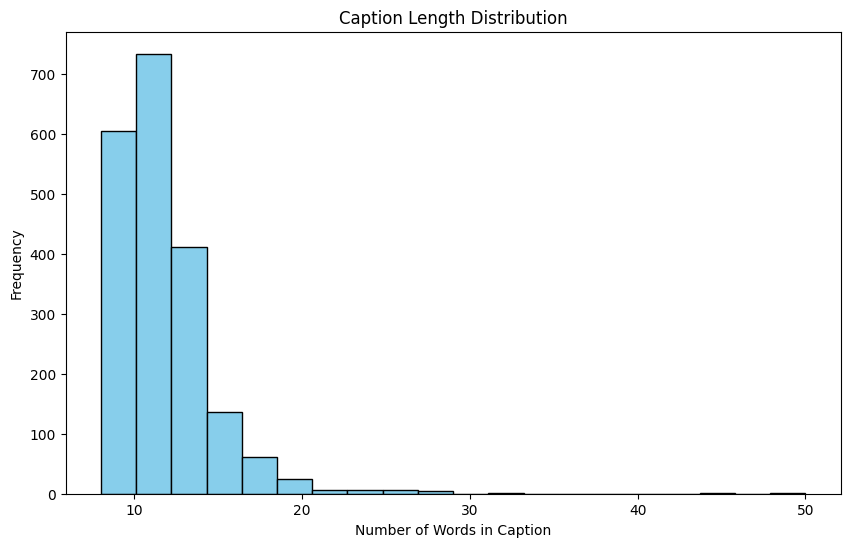


Total unique words: 2637
Most common words: [('a', 3460), ('of', 798), ('on', 709), ('in', 603), ('the', 562), ('with', 535), ('and', 456), ('to', 275), ('man', 264), ('is', 243)]


<ipython-input-22-5e1ccc618f63>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


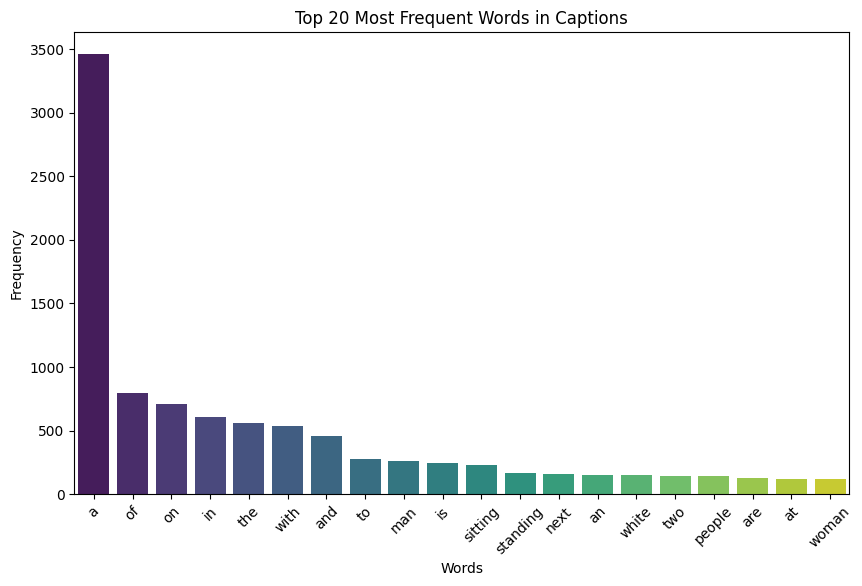

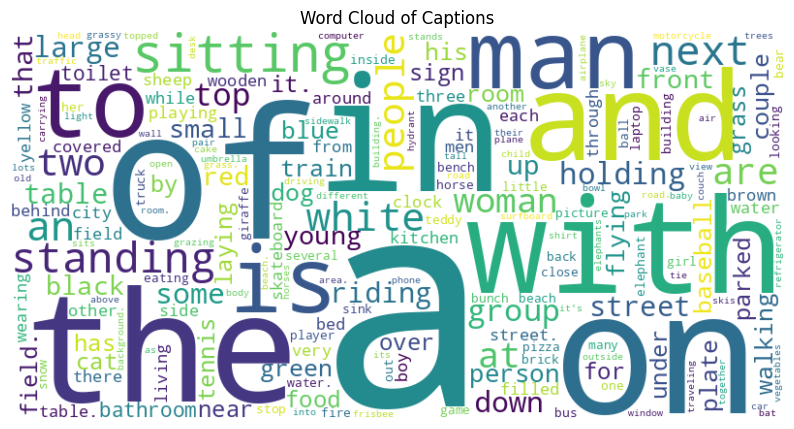

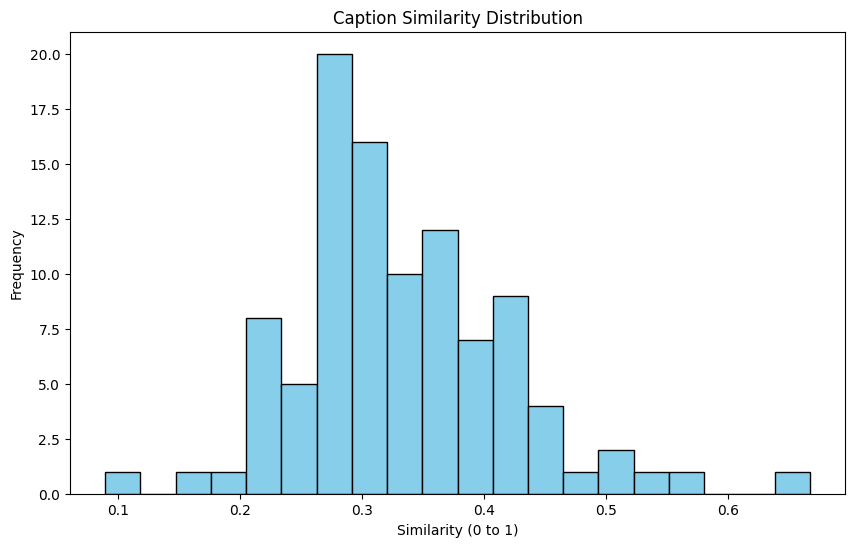

In [ ]:

from itertools import combinations
import seaborn as sns
import pandas as pd
from difflib import SequenceMatcher
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#캡션 길이 분석
def analyze_caption_length(dataset):
    lengths = []
    for img_inputs, input_ids, _, _ in dataset:
        if input_ids is not None:
            # 패딩 토큰 제외한 토큰의 개수를 세어 캡션 길이를 계산
            caption_length = torch.sum(input_ids != tokenizer.pad_token_id).item()
            lengths.append(caption_length)
    return lengths


from collections import Counter

#단어 빈도 분석
def analyze_word_frequency(dataset):
    word_counter = Counter() #캡션 내 단어 빈도 저장한 Counter()객체
    for _, input_ids, _, _ in dataset:
        if input_ids is not None:
            # 토크나이저를 사용해 input_ids를 단어로 변환
            words = tokenizer.decode(input_ids, skip_special_tokens=True).lower().split()
            word_counter.update(words)
    return word_counter


# 캡션 길이 분석
caption_lengths = analyze_caption_length(train_loader.dataset)
print(f"Number of captions: {len(caption_lengths)}")
print(f"Average caption length: {sum(caption_lengths)/len(caption_lengths):.2f} words")

# 캡션 길이 분포 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(caption_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Caption Length Distribution')
plt.xlabel('Number of Words in Caption')
plt.ylabel('Frequency')
plt.show()
print()

# 단어 빈도 분석
word_counter = analyze_word_frequency(train_loader.dataset)
print(f"Total unique words: {len(word_counter)}") #고유 단어 개수
print("Most common words:", word_counter.most_common(10)) #가장 빈도수 높은 단어

# 가장 빈번한 단어 20개의 막대 그래프 생성
most_common_words = word_counter.most_common(20)
if most_common_words:
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette='viridis')
    plt.title('Top 20 Most Frequent Words in Captions')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45) #x축 단어 각도 조절
    plt.show()
else:
    print("No words found in the captions.")

print()
# 워드 클라우드-시각화
def generate_word_cloud(word_counter):
    # Counter 객체를 워드 클라우드 생성에 맞게 딕셔너리로 변환
    word_freq_dict = dict(word_counter)

    # 워드 클라우드 객체 만들기
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)

    # 워드 클라우드 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off") #축 없앰
    plt.title("Word Cloud of Captions")
    plt.show()

word_counter = analyze_word_frequency(train_loader.dataset)
generate_word_cloud(word_counter)


# 캡션 사이의 유사도를 SequenceMatcher를 통해 계산
def caption_similarity(caption1, caption2):
    return SequenceMatcher(None, caption1, caption2).ratio()

# 캡션 다양성 분석
def analyze_caption_diversity(coco_dataset, num_pairs=100):
    captions = []

    # 데이터셋에서 모든 캡션 수집
    for img_id in coco_dataset.getImgIds():
        ann_ids = coco_dataset.getAnnIds(imgIds=img_id)
        anns = coco_dataset.loadAnns(ann_ids)
        if anns:
            captions.append(anns[0]['caption'])


    similarities = []
    # 랜덤 캡션 쌍들 간 유사도 계산
    for _ in range(num_pairs):
        caption1, caption2 = random.sample(captions, 2)
        similarity = caption_similarity(caption1, caption2)
        similarities.append(similarity)

    return similarities

print()

#히스토그램
def plot_caption_diversity(similarities):
    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=20, color='skyblue', edgecolor='black')
    plt.title('Caption Similarity Distribution')
    plt.xlabel('Similarity (0 to 1)')
    plt.ylabel('Frequency')
    plt.show()

# 캡션 다양성 분석과 시각화
similarities = analyze_caption_diversity(coco_train_captions, num_pairs=100)
plot_caption_diversity(similarities)


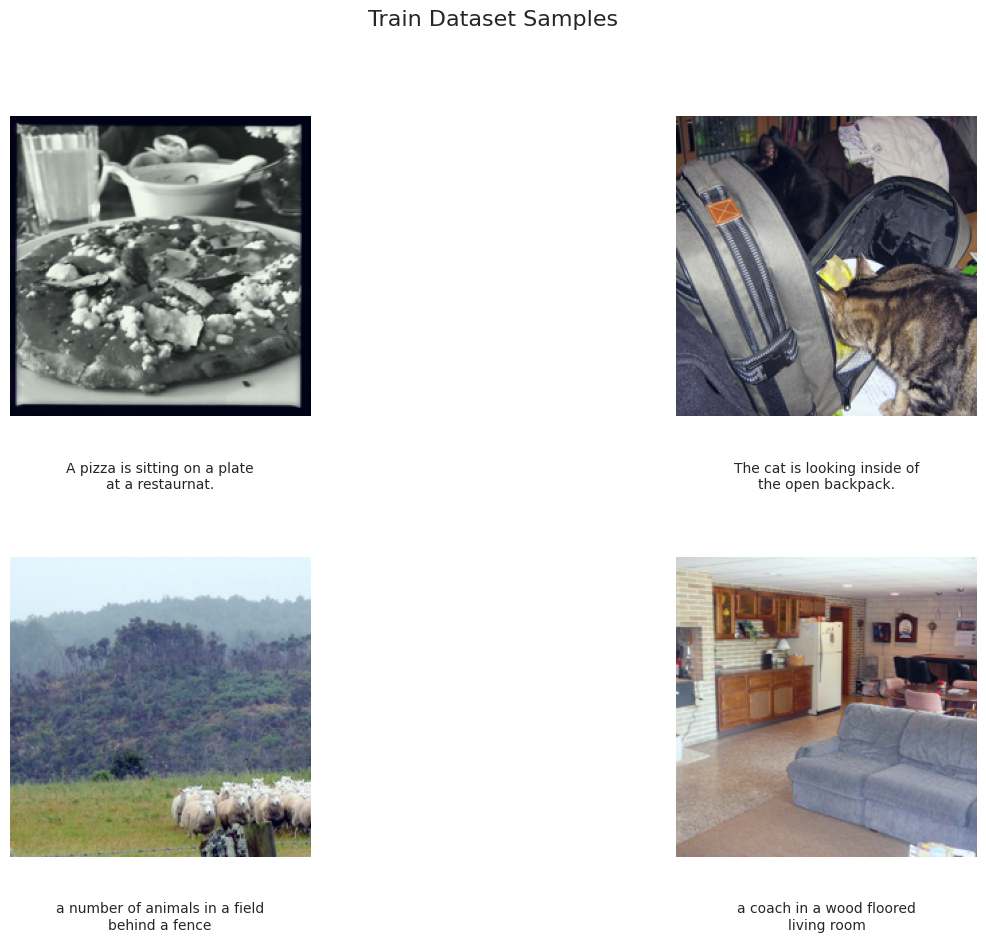

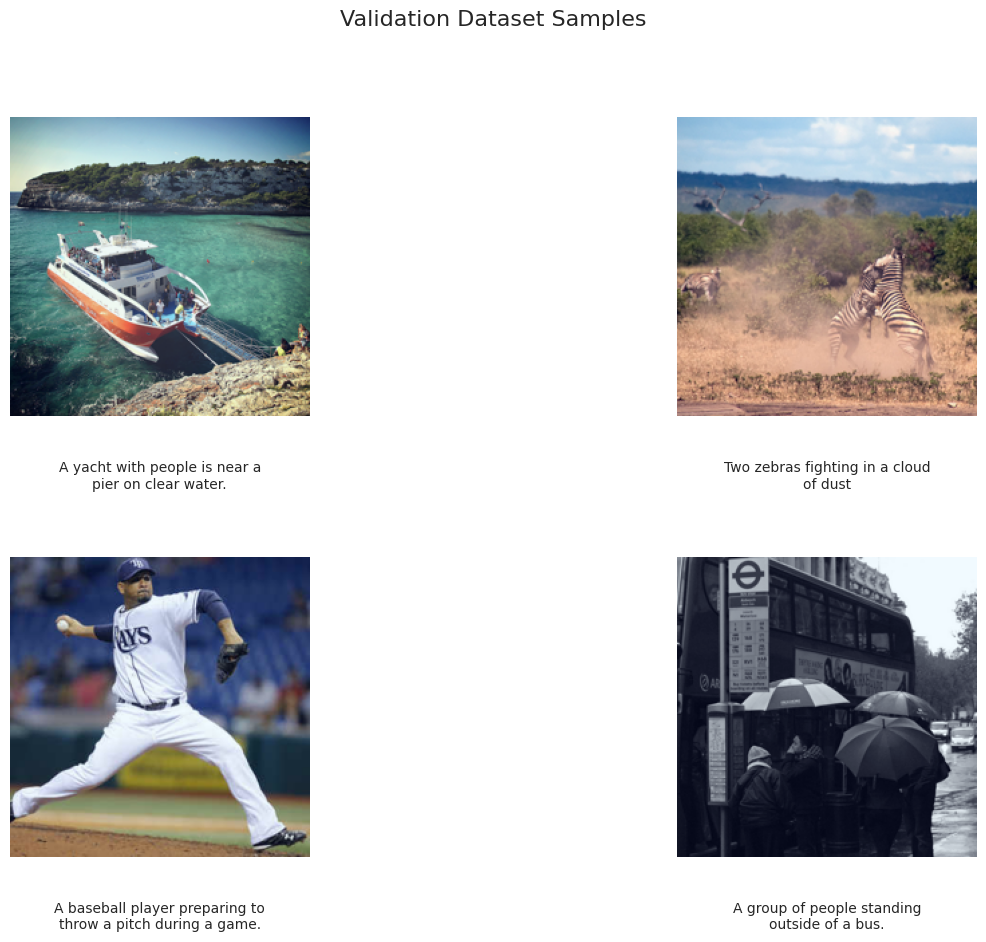

In [ ]:

import numpy as np
import seaborn as sns
from textwrap import wrap

# 이미지 보여줄 크기 조정
def rescale_image(image_tensor):
    image = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    return (image * 255).astype(np.uint8)  #0~255 범위로
#이미지 캡션 같이 보여줄 함수
def display_images_with_captions(images, captions, title):
    sns.set_style("white")

    fig, axs = plt.subplots(2, 2, figsize=(10, 10)) #같이 ploting
    fig.suptitle(title, fontsize=16, y=1.0)

    axs = axs.flatten() #1차원 배열로 만들어서 인덱싱하기 위해

    for idx, ax in enumerate(axs):
        if idx < len(images):
            # 이미지 재조정
            image = rescale_image(images[idx].cpu().numpy().transpose(1, 2, 0))
            ax.imshow(image)
            ax.axis('off')
            caption = "\n".join(wrap(captions[idx], 30))  # 캡션이 30자 넘어가면 줄바꾸도록
            ax.imshow(image)
            ax.axis('off')
            plt.text(0.5, -0.15, caption, fontsize=10, ha='center', va='top', transform=ax.transAxes)
    plt.tight_layout(pad=1.2)
    plt.show()

# 이미지,캡션 가져오는 함수
def get_images_and_captions_from_loader(loader, num_images=4):
    images, captions, _, objects = next(iter(loader)) #데이터 로더에서 배치 가져오기
    images = images[:num_images] #지정된 개수만큼 이미지 선택
    captions = captions[:num_images] #지정된 개수만큼 캡션 선택
    captions_text = [tokenizer.decode(capt, skip_special_tokens=True) for capt in captions]
    return images, captions_text

#학습 데이터셋에서 4개의 이미지와 캡션 보여주기
train_images, train_captions = get_images_and_captions_from_loader(train_loader, num_images=4)
display_images_with_captions(train_images, title="Train Dataset Samples", captions=train_captions)
print()
# 검증 데이터셋에서 4개의 이미지와 캡션 보여주기
val_images, val_captions = get_images_and_captions_from_loader(val_loader, num_images=4)
display_images_with_captions(val_images, title="Validation Dataset Samples", captions=val_captions)

## **Clip(이미지)-GPT(텍스트) Mapper 통해 이미지-텍스트 매핑**

In [ ]:

class EncoderAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, dropout=0.1):
      #self-attention 레이어 정의
        super(EncoderAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True, dropout=dropout) #임베딩 차원,멀티 헤드 수,드롭 아웃 비율
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
      #입력 텐서에 self-attention
        attn, _ = self.mha(query=x, value=x, key=x, need_weights=False)
        x = x + attn
        return self.layernorm(x) #정규화된 self-attention 값

# FeedForward 클래스
class FeedForward(nn.Module):
  #임베딩 차원,드롭 아웃 비율
    def __init__(self, embed_dim=768, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2), #확장
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim), #원래로
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.seq(x) #입력 텐서에 fedd forward
        return self.layernorm(x) #정규화 시킨 feed forward 값

# Attention-feed forward 결합 transformer 레이어
class MapperLayer(nn.Module):
  #임베딩 차원,멀티 헤드 수,드롭 아웃 비율
    def __init__(self, embed_dim=768, num_heads=8, dropout_rate=0.1):
        super(MapperLayer, self).__init__()
        self.attn = EncoderAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout_rate)
        self.ff = FeedForward(embed_dim=embed_dim, dropout_rate=dropout_rate)

    def forward(self, x):
        x = self.attn(x)
        x = self.ff(x)
        return x

# Transformer Mapper-CLIP 임베딩을 GPT 임베딩으로 변환
class TransformerMapper(nn.Module):
    def __init__(self, dim_clip=512, embed_dim=768, clip_length=16, num_layers=8, num_heads=8, dropout_rate=0.1):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length  # CLIP 임베딩의 길이
        self.linear = nn.Linear(dim_clip, embed_dim)  # Map CLIP embedding dimension to GPT-2 embedding dimension
        self.transformer = nn.ModuleList([
            MapperLayer(embed_dim=embed_dim, num_heads=num_heads, dropout_rate=dropout_rate)
            for _ in range(num_layers) #Transformer 레이어 수
        ])

    def forward(self, clip_embeddings):
        # 차원 맞춰주는 코드
        x = self.linear(clip_embeddings)  # 선형 변환
        #  x를 batch_size, clip_length, embed_dim에 맞게 reshape
        for layer in self.transformer:
            x = layer(x)
        return x

# Linear mapper
class LinearClipToGptMapper(nn.Module):
    def __init__(self, dim_clip=512, dim_gpt=768):

        super(LinearClipToGptMapper, self).__init__()
        self.linear = nn.Linear(dim_clip, dim_gpt)  #선형 변환

    def forward(self, clip_embeddings):
        clip_embeddings_mapped = self.linear(clip_embeddings)
        return clip_embeddings_mapped


# clip-gpt 연결
class ClipToGptModel(nn.Module):
    def __init__(self, clip_model, gpt_model, transformer_mapper):
        super(ClipToGptModel, self).__init__()
        self.clip_model = clip_model  # 사전학습 CLIP model
        self.gpt_model = gpt_model  # 사전학습 GPT-2 model
        self.transformer_mapper = transformer_mapper  # CLIP-GPT 매핑을 위한 Transformer

    #이미지를 입력받아 CLIP과 GPT 모델을 통해 캡션 생성
    def forward(self, images, input_ids=None, labels=None):
         #CLIP 임베딩 추출
        clip_embedding = self.clip_model.get_image_features(pixel_values=images)  #batch_size, clip_length, dim_clip

        #CLIP 임베딩-GPT 임베딩 변환 transformer_mapper 이용
        clip_embeddings_mapped = self.transformer_mapper(clip_embedding)
        #GPT 토큰 임베딩
        max_length = input_ids.size(1)
        token_embeddings = self.gpt_model.transformer.wte(input_ids[:, :max_length])

        #CLIP 임베딩과 GPT 임베딩 결합 cat 함수 이용
        combined_embeddings = torch.cat((clip_embeddings_mapped.unsqueeze(1), token_embeddings), dim=1)
        # print(f"combined_embeddings shape: {combined_embeddings.shape}")
        # Attention mask 생성
        attention_mask = torch.cat([
            torch.ones(clip_embeddings_mapped.size()[:-1], device=combined_embeddings.device).unsqueeze(1),
            torch.ones(token_embeddings.size()[:-1], device=combined_embeddings.device)
        ], dim=1)
        # print(f"attention_mask shape: {attention_mask.shape}")
                # Adjust labels to match the combined embeddings' sequence length
        if labels is not None:
            #CLIP 임베딩에 해당하는 위치를 손실 계산에서 제외하기 위해
            pad_labels = torch.full((labels.size(0), 1), -100, dtype=labels.dtype, device=labels.device)
            # Concatenate the padding to the labels
            padded_labels = torch.cat([pad_labels, labels], dim=1)  #batch_size, sequence_length + 1 CLIP 토큰 위치 제외
            # print(f'padded_labels shape: {padded_labels.shape}')
        else:
            padded_labels = None
        # print(f'labels shape:{labels.shape}')
        # print(f'GPT 2 Config: {self.gpt_model.config}')

        try:
            outputs = self.gpt_model(
                input_ids = None,
                inputs_embeds=combined_embeddings,
                attention_mask=attention_mask,
                labels=padded_labels
            )
            # print(f"outputs shape: {outputs.logits.shape}")
        except Exception as e:
            print(f"Error during GPT forward pass: {e}")
            raise

        return outputs


transformer_mapper = LinearClipToGptMapper(dim_clip=512, dim_gpt=768)
model = ClipToGptModel(clip_model, gpt_model, transformer_mapper).to(device)

## clip+gpt 모델 학습,시각화 함수 정의


In [ ]:
import os
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler

# 지표
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# gpu 환경이 아닌 지금은 cpu에서 실행
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Path to save logs and models
LOG_DIR = "/content/drive/MyDrive/COCO_subset/logs_clip_gpt"
os.makedirs(LOG_DIR, exist_ok=True)
SAVE_PATH = "/content/drive/MyDrive/COCO_subset/clip_gpt_caption_model.pth"

def generate_caption(image_tensor, model, transformer_mapper, tokenizer, max_length=50, temperature=0.7):
    model.eval()

    try:
        # Get CLIP image embeddings and map to GPT space
        with torch.no_grad():
            clip_embedding = model.clip_model.get_image_features(pixel_values=image_tensor.to(device).unsqueeze(0))
            print(f"clip_embedding shape: {clip_embedding.shape}")
            mapped_embedding = transformer_mapper(clip_embedding).unsqueeze(1)
            print(f"mapped_embedding shape: {mapped_embedding.shape}")
        # Generate an attention mask (1 for all tokens since no padding is needed in embeddings)
        attention_mask = torch.ones(mapped_embedding.size()[:-1], device=device)

        # Generate caption using GPT-2's generate() method
        generated_ids = model.gpt_model.generate(
            inputs_embeds=mapped_embedding,
            attention_mask=attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=70,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True
        )

        # Decode generated token IDs to text
        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption

    except Exception as e:
        print(f"Error generating caption: {e}")
        return "Error in generating caption"

# Logger function
def log_to_file(epoch, train_loss, val_loss, metrics):
    log_path = os.path.join(LOG_DIR, "training_log.txt")
    with open(log_path, "a") as f:
        f.write(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n")
        if metrics:
            f.write(f"BLEU: {metrics['bleu']}\nCIDEr: {metrics['cider']:.4f}, SPICE: {metrics['spice']:.4f}\n")
        f.write("\n")
    print(f"Logged epoch {epoch} to {log_path}")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)

criterion = torch.nn.CrossEntropyLoss()

# Plotting function for loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(os.path.join(LOG_DIR, "loss_plot.png"))
    plt.show()

def plot_metrics(bleu_scores, cider_scores, spice_scores):
    epochs = range(1, len(bleu_scores) + 1)  # Assuming BLEU has 4 scores (BLEU-1 to BLEU-4)

    plt.figure(figsize=(15, 5))

    # Plot BLEU scores (1 to 4)
    for i in range(4):
        plt.plot(epochs, [bleu[i] for bleu in bleu_scores], label=f"BLEU-{i+1}")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Scores")
    plt.title("BLEU Scores Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "bleu_scores.png"))
    plt.show()

    # Plot CIDEr scores
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, cider_scores, label="CIDEr", marker='o', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("CIDEr Score")
    plt.title("CIDEr Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "cider_scores.png"))
    plt.show()

    # Plot SPICE scores
    plt.figure(figsize=(7, 5))
    plt.plot(epochs, spice_scores, label="SPICE", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("SPICE Score")
    plt.title("SPICE Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "spice_scores.png"))
    plt.show()

# Training function
def train(model, data_loader, val_loader, optimizer, criterion, scheduler, epochs, patience=3, save_path=SAVE_PATH):
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision
    train_losses, val_losses = [], []
    bleu_scores_list, cider_scores_list, spice_scores_list = [], [], []

    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, (images, input_ids, labels, _) in enumerate(data_loader):
            images, labels, input_ids = images.to(device), labels.to(device), input_ids.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, input_ids, labels)
            loss = outputs.loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}, Loss: {loss.item()}")

            progress_bar.set_postfix(loss=loss.item())
            progress_bar.update()

        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Average Train Loss: {avg_loss:.4f}")
        train_losses.append(avg_loss)

        # Run validation step after each epoch
        avg_val_loss, metrics = validate(model, val_loader, criterion)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        val_losses.append(avg_val_loss)

        if metrics:
            bleu_scores_list.append(metrics["bleu"])
            cider_scores_list.append(metrics["cider"])
            spice_scores_list.append(metrics["spice"])
        else:
            print(f"Metrics missing for epoch {epoch+1}. Skipping.")

        # Log training progress to a file
        log_to_file(epoch+1, avg_loss, avg_val_loss, metrics)

        # Update the learning rate scheduler
        scheduler.step(avg_loss)

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
            # Save the best model
            print(f"Validation loss improved. Saving model to {SAVE_PATH}")
            torch.save(model.state_dict(), SAVE_PATH)
        else:
            no_improvement_count += 1
            print(f"No improvement in validation loss for {no_improvement_count} epochs.")

        if no_improvement_count >= patience:
            print("Early stopping triggered.")
            # early stopping 일어나면 손실,지표 시각화
            progress_bar.close()
            plot_losses(train_losses, val_losses)
            plot_metrics(bleu_scores_list, cider_scores_list, spice_scores_list)
            break


    # 학습이 끝나면 손실 시각화
    plot_losses(train_losses, val_losses)

    # 학습이 끝나면 지표에 따른 시각화
    plot_metrics(bleu_scores_list, cider_scores_list, spice_scores_list)

from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

def calculate_metrics(generated_captions, reference_captions):
    # Prepare the data for COCOEvalCap directly from captions
    gts = {idx: [ref] for idx, ref in enumerate(reference_captions)}  # ground truth (reference captions)
    res = {idx: [gen] for idx, gen in enumerate(generated_captions)}  # generated captions

    # Initialize metric scorers
    bleu_scorer = Bleu(4)
    cider_scorer = Cider()
    spice_scorer = Spice()

    # Compute BLEU scores
    bleu_scores, _ = bleu_scorer.compute_score(gts, res)

    # Compute CIDEr score
    cider_score, _ = cider_scorer.compute_score(gts, res)

    # Compute SPICE score
    spice_score, _ = spice_scorer.compute_score(gts, res)

    return bleu_scores, cider_score, spice_score



# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    generated_captions = []
    reference_captions = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validating")):
            images, input_ids, labels, _ = batch
            images, input_ids, labels = images.to(device), input_ids.to(device), labels.to(device)

            outputs = model(images, input_ids, labels=labels)
            logits = outputs.logits[:, :-1, :]
            loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            total_loss += loss.item()

            for i, img in enumerate(images):
                generated_caption = generate_caption(img, model, transformer_mapper, tokenizer)
                generated_captions.append(generated_caption)
                reference_caption = tokenizer.decode(labels[i], skip_special_tokens=True)
                reference_captions.append(reference_caption)

    avg_loss = total_loss / len(val_loader)

    # Calculate BLEU, CIDEr, and SPICE using pycocoevalcap
    try:
        bleu_scores, cider_score, spice_score = calculate_metrics(generated_captions, reference_captions)
        metrics = {
            "bleu": bleu_scores,
            "cider": cider_score,
            "spice": spice_score
        }
    except Exception as e:
        print(f"Error during metrics calculation: {e}")
        metrics = None

    return avg_loss, metrics


Using device: cuda


Epoch 1/30:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 11.41258430480957
Batch 10, Loss: 1.100514531135559
Batch 20, Loss: 0.9449767470359802
Batch 30, Loss: 0.9291166067123413
Batch 40, Loss: 0.8124945163726807
Batch 50, Loss: 0.846752405166626
Batch 60, Loss: 0.7161930203437805
Epoch [1/30], Average Train Loss: 1.0850


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])

Epoch 2/30:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.6343724131584167
Batch 10, Loss: 0.7702548503875732
Batch 20, Loss: 0.6366249322891235
Batch 30, Loss: 0.5764271020889282
Batch 40, Loss: 0.5727914571762085
Batch 50, Loss: 0.7332766056060791
Batch 60, Loss: 0.6525999307632446
Epoch [2/30], Average Train Loss: 0.6584


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])

Epoch 3/30:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.514223575592041
Batch 10, Loss: 0.46581295132637024
Batch 20, Loss: 0.5345794558525085
Batch 30, Loss: 0.554060697555542
Batch 40, Loss: 0.5272731781005859
Batch 50, Loss: 0.4679175317287445
Batch 60, Loss: 0.6267158389091492
Epoch [3/30], Average Train Loss: 0.5297


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])

Epoch 4/30:   0%|          | 0/63 [00:00<?, ?it/s]

Batch 0, Loss: 0.41078436374664307
Batch 10, Loss: 0.40298593044281006
Batch 20, Loss: 0.4024878442287445
Batch 30, Loss: 0.45084819197654724
Batch 40, Loss: 0.4503750205039978
Batch 50, Loss: 0.49638688564300537
Batch 60, Loss: 0.4476623237133026
Epoch [4/30], Average Train Loss: 0.4271


Validating:   0%|          | 0/7 [00:00<?, ?it/s]

clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])
clip_embedding shape: torch.Size([1, 512])
mapped_embedding shape: torch.Size([1, 1, 768])

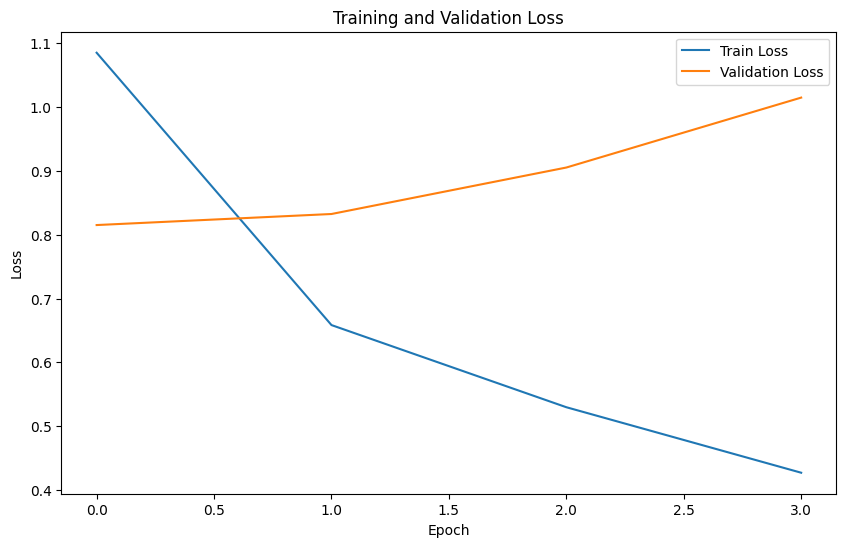

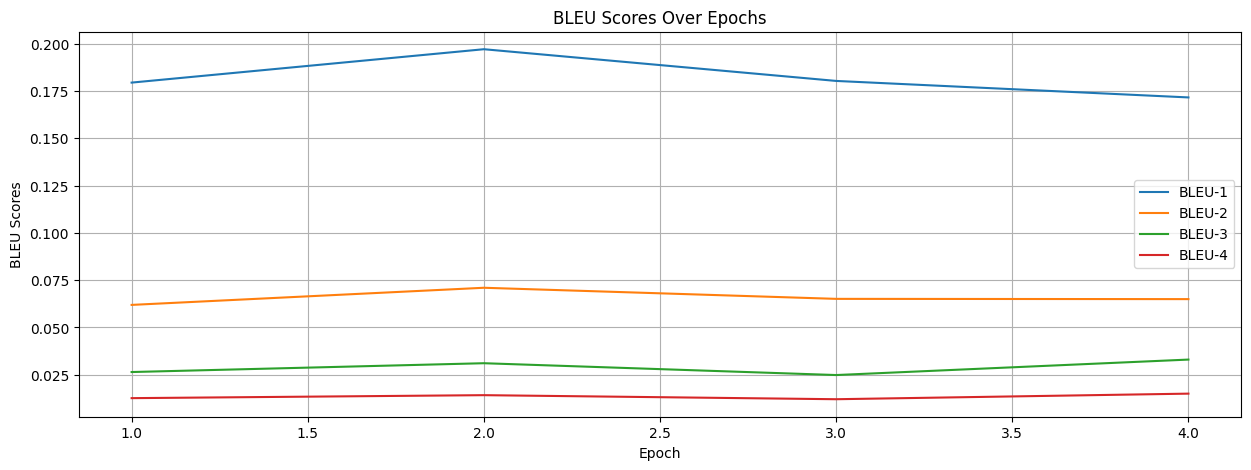

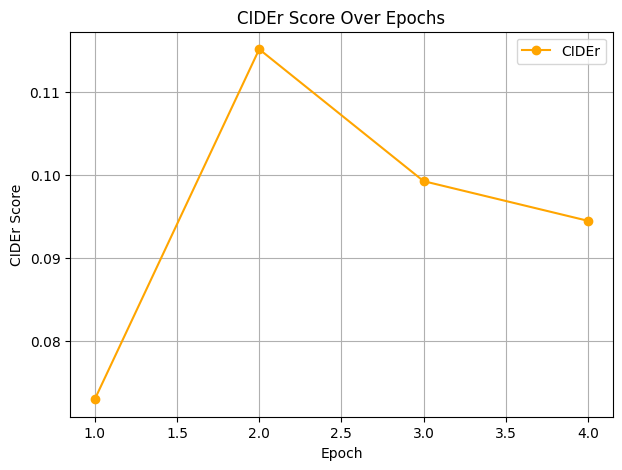

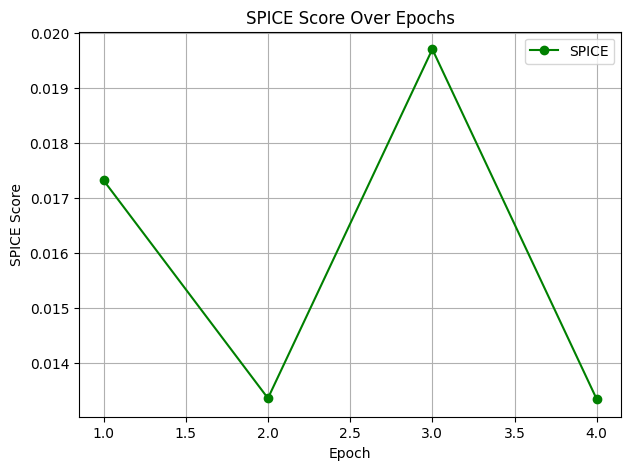

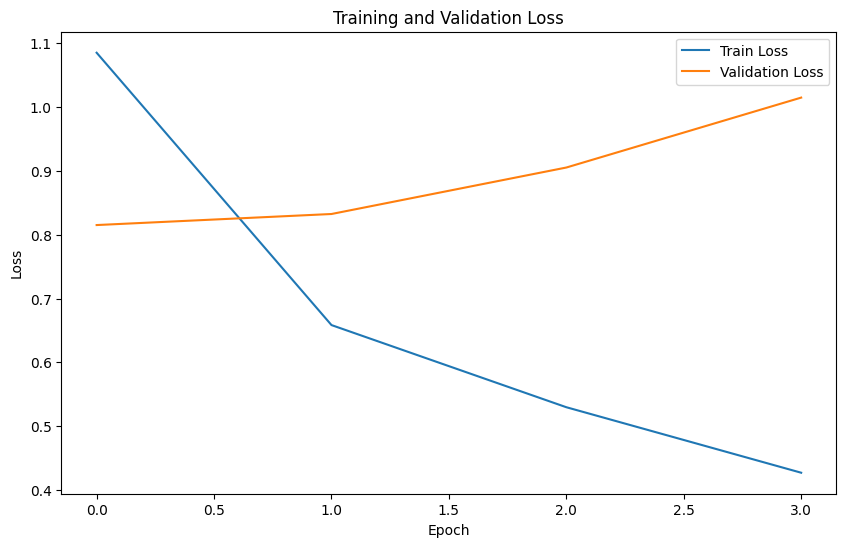

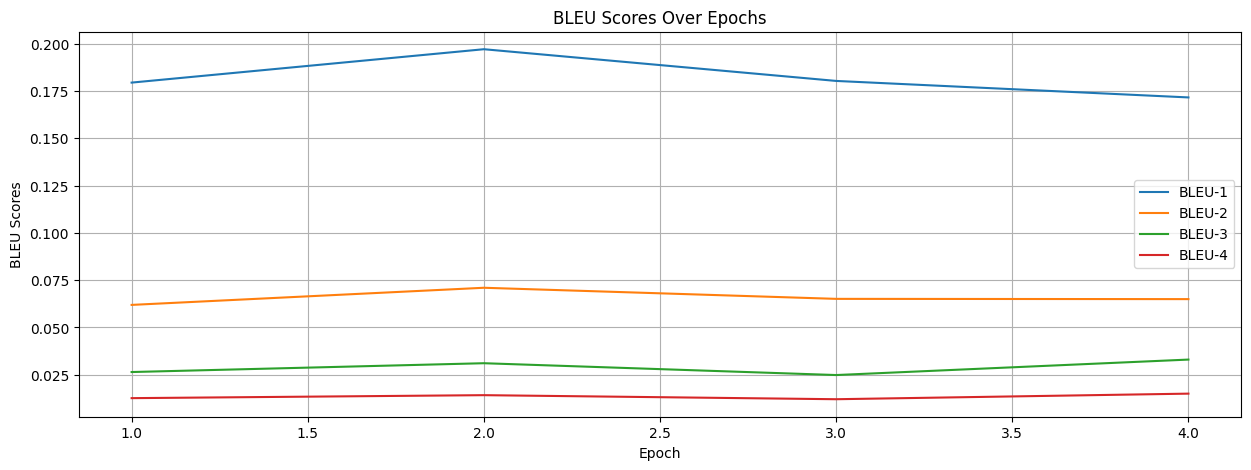

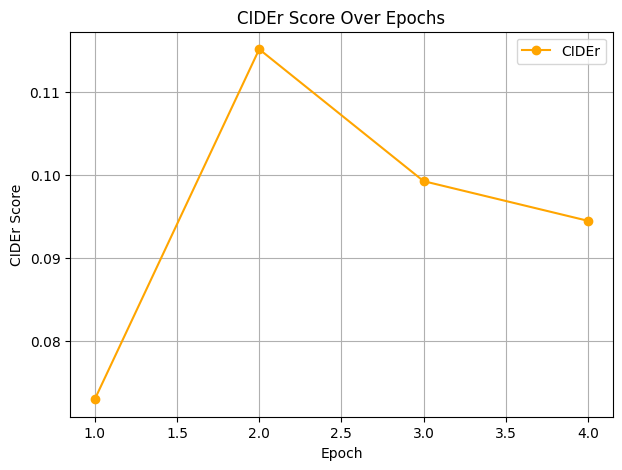

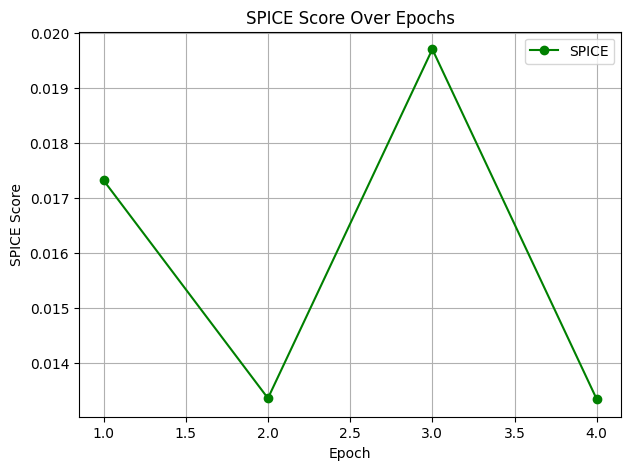

In [ ]:
#학습
train(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=30, save_path=SAVE_PATH)

# **학습되지 않은 데이터셋에도 적합한 캡션이 생기는지 확인**

In [ ]:

import traceback
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def load_model_weights(model, weight_path):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    return model

def sample_from_logits(logits, temperature=0.2, top_k=50):
    # Check for NaN or invalid logits
    if torch.isnan(logits).any():
        raise ValueError("Logits contain NaN values")

    # Apply temperature scaling
    logits = logits / temperature

    # Apply top-k sampling (only keep top-k logits)
    top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
    print(f"Top-k logits shape: {top_k_logits.shape}, Top-k indices shape: {top_k_indices.shape}")

    # Convert logits to probabilities
    probabilities = torch.softmax(top_k_logits, dim=-1)

    # Sample from top-k probabilities
    sampled_token_in_top_k = torch.multinomial(probabilities, num_samples=1)
    print(f"Sampled token (in top-k space): {sampled_token_in_top_k.item()}")

    # Map the sampled token back to the original vocabulary using top_k_indices
    next_token = top_k_indices.gather(-1, sampled_token_in_top_k)
    print(f"Next token index (in original vocab): {next_token.item()}")

    # Ensure the sampled token is within the valid range of the vocabulary
    vocab_size = logits.size(-1)  # Get vocab size from logits
    if next_token.item() >= vocab_size or next_token.item() < 0:
        raise ValueError(f"Sampled token index {next_token.item()} is out of bounds for vocab size {vocab_size}")

    return next_token


# Get CLIP image embeddings
def get_image_tensor(image):
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        clip_embedding = model.clip_model.get_image_features(pixel_values=inputs.pixel_values)

    return clip_embedding

def check_forward_pass(image, input_ids):
    # Preprocess image
    inputs = clip_processor(images=image, return_tensors="pt").to(device)

    # Get CLIP image embeddings
    with torch.no_grad():
        clip_embedding = model.clip_model.get_image_features(pixel_values=inputs.pixel_values)

    # Ensure that the CLIP embeddings are properly reshaped to be fed into GPT-2
    clip_embedding = clip_embedding.unsqueeze(1)

    # Forward pass through the model
    output = model(inputs_embeds=clip_embedding, input_ids=input_ids)
    logits = output.logits

    return logits


# Gradio function to display the debug information
def gradio_caption(image):
    try:
        # Call the caption generation function with the necessary arguments
        image_tensor = clip_processor(images=image, return_tensors="pt").pixel_values.squeeze(0)
        result = generate_caption(image_tensor, model, transformer_mapper, tokenizer)
        return result
    except Exception as e:
        # Capture and print the error traceback
        error_message = traceback.format_exc()
        return f"Error occurred: {str(e)}"

# Initialize Gradio interface
iface = gr.Interface(fn=gradio_caption,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="CLIP-GPT Image Captioning")

# Launch the interface
iface.launch(debug=False)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ce6b015bcf6d95f202.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **BLIP-2: Image Captioning**

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
import os
from pycocotools.coco import COCO
import random

# Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP-1 processor and model
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

# Check special tokens in the tokenizer
print("Special tokens in the tokenizer:")
print(f"PAD: {processor.tokenizer.pad_token_id}")
print(f"UNK: {processor.tokenizer.unk_token_id}")
print(f"SEP: {processor.tokenizer.sep_token_id}")
print(f"CLS: {processor.tokenizer.cls_token_id}")

# File paths
COCO_DIR="/content/drive/MyDrive/COCO_subset"
TRAIN_IMAGES_DIR = os.path.join(COCO_DIR, 'train2017/train2017')
VAL_IMAGES_DIR = os.path.join(COCO_DIR, 'val2017/val2017')
TRAIN_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_train2017.json')
VAL_ANNOTATIONS_FILE = os.path.join(COCO_DIR, 'annotations/annotations', 'captions_val2017.json')

# Load COCO captions
coco_train = COCO(TRAIN_ANNOTATIONS_FILE)
coco_val = COCO(VAL_ANNOTATIONS_FILE)

# Get list of downloaded image file names
def get_downloaded_image_ids(images_dir):
    return {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}

# Get image IDs
train_image_ids = get_downloaded_image_ids(TRAIN_IMAGES_DIR)
val_image_ids = get_downloaded_image_ids(VAL_IMAGES_DIR)


# Custom dataset for BLIP-1
class BLIP1CustomDataset(Dataset):
    def __init__(self, coco, images_dir, processor, available_image_ids):
        self.coco = coco
        self.images_dir = images_dir
        self.processor = processor
        self.image_ids = [img_id for img_id in coco.getImgIds() if str(img_id).zfill(12) in available_image_ids]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_filename = os.path.join(self.images_dir, img_info['file_name'])

        try:
            # Load image and check for validity
            image = Image.open(img_filename).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_filename}: {e}")
            return None  # Skip the invalid image

        # Get caption
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        caption = anns[0]['caption'] if anns else ""

        if not caption:
            print(f"Missing or empty caption for image {img_filename}")
            return None  # Skip the image if caption is missing

        # Process the image and caption
        inputs = self.processor(images=image, text=caption, return_tensors="pt", padding="max_length")

        # Remove batch dimension and return
        pixel_values = inputs['pixel_values'].squeeze(0)
        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return {'pixel_values': pixel_values, 'input_ids': input_ids, 'attention_mask': attention_mask,
                'img_id': img_id}

# Initialize DataLoader
def initialize_dataloaders(train_image_ids, val_image_ids, batch_size=8, num_workers=4):
    train_dataset = BLIP1CustomDataset(coco_train, TRAIN_IMAGES_DIR, processor, train_image_ids)
    val_dataset = BLIP1CustomDataset(coco_val, VAL_IMAGES_DIR, processor, val_image_ids)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# Initialize data loaders
train_loader, val_loader = initialize_dataloaders(train_image_ids, val_image_ids)
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Special tokens in the tokenizer:
PAD: 0
UNK: 100
SEP: 102
CLS: 101
loading annotations into memory...
Done (t=0.98s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Number of training batches: 13127
Number of validation batches: 625


문제-rain_image_ids 또는 val_image_ids의 길이가 0이라면, 이미지 파일 이름과 COCO 어노테이션의 file_name 필드가 일치하지 않을 가능성이 큽니다.

In [ ]:
print("Number of train_image_ids:", len(train_image_ids))
print("Number of val_image_ids:", len(val_image_ids))


Number of train_image_ids: 0
Number of val_image_ids: 0


In [ ]:
print("First 10 image IDs in COCO train:", coco_train.getImgIds()[:10])
print("First 10 train_image_ids:", list(train_image_ids)[:10])


First 10 image IDs in COCO train: [391895, 522418, 184613, 318219, 554625, 574769, 60623, 309022, 5802, 222564]
First 10 train_image_ids: []


In [ ]:
import os

train_images = os.listdir(TRAIN_IMAGES_DIR)  # TRAIN_IMAGES_DIR에 있는 파일 리스트
print(f"Number of images in TRAIN_IMAGES_DIR: {len(train_images)}")
print("First 10 images in directory:", train_images[:10])


Number of images in TRAIN_IMAGES_DIR: 1
First 10 images in directory: ['train2017']


In [ ]:
# TRAIN_IMAGES_DIR에서 파일 이름을 확인
train_images = os.listdir(TRAIN_IMAGES_DIR)

# 첫 10개 파일 이름 출력
print("First 10 train image file names:", train_images[:10])

# 파일 이름 형식이 12자리 zero-padding인지 확인
for filename in train_images[:10]:
    if len(os.path.splitext(filename)[0]) != 12:
        print(f"Filename {filename} does not have a 12-character ID.")


First 10 train image file names: ['train2017']
Filename train2017 does not have a 12-character ID.


### **시각화**

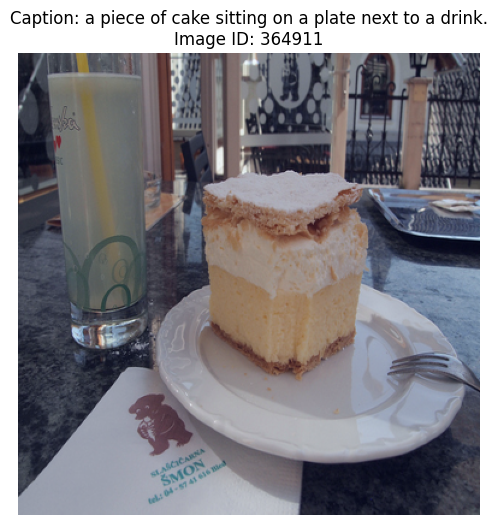

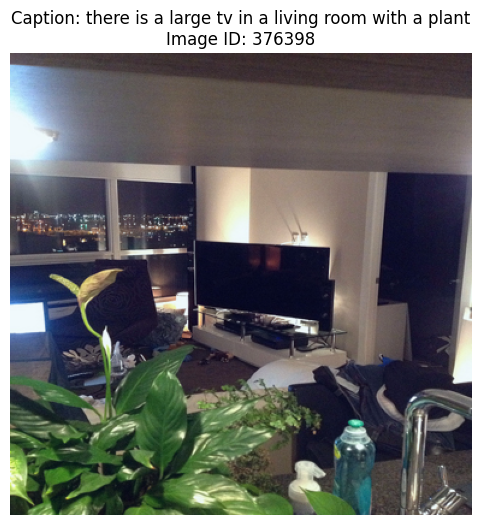

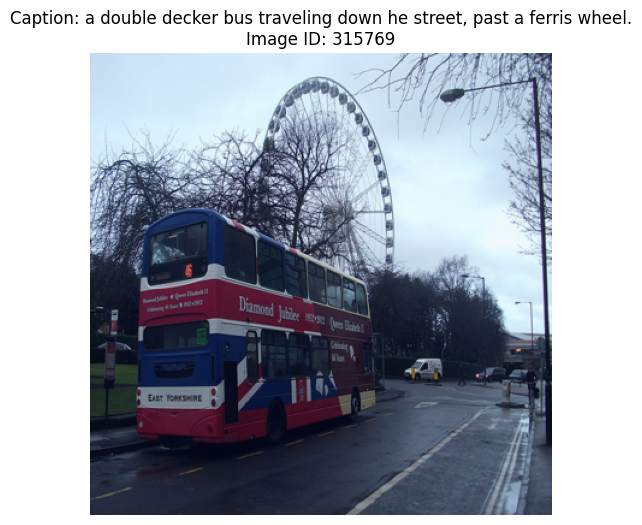

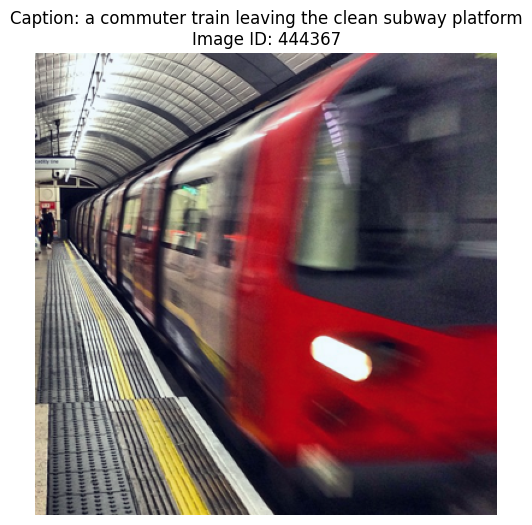

In [ ]:

import matplotlib.pyplot as plt

# Function to display images with their captions
def visualize_samples(data_loader, num_samples=4):
    """
    Display a few samples from the data loader with their captions.

    Args:
    - data_loader: DataLoader object to fetch samples from.
    - num_samples: Number of samples to display.
    """
    # Get a batch from the data loader
    batch = next(iter(data_loader))
    images = batch['pixel_values']
    captions = batch['input_ids']
    img_ids = batch['img_id']

    # Check if there are enough samples to display
    if num_samples > len(images):
        num_samples = len(images)

    # Display the samples
    for i in range(num_samples):
        # Convert the image tensor to a PIL image for visualization
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

        # Decode the caption
        caption = processor.decode(captions[i], skip_special_tokens=True)

        # Display the image and its caption
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Caption: {caption}\nImage ID: {img_ids[i]}")
        plt.show()

# Visualize a few samples from the training dataset
visualize_samples(train_loader, num_samples=4)


## **blip 모델 학습,시각화 함수 정의**

In [7]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths for saving logs and models
LOG_DIR = "/content/drive/MyDrive/COCO_subset/logs_blip"
SAVE_PATH = "/content/drive/MyDrive/COCO_subset/blip_caption_model.pth"

# Create directories if they don't exist
import os
os.makedirs(LOG_DIR, exist_ok=True)


# Optimizer and scheduler initialization
def initialize_optimizer_and_scheduler(model, lr=5e-4):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    return optimizer, scheduler

# Function to generate captions
def generate_caption(image_tensor, model, transformer_mapper, tokenizer, max_length=50, temperature=0.7):
    model.eval()
    try:
        with torch.no_grad():
            clip_embedding = model.clip_model.get_image_features(pixel_values=image_tensor.to(device).unsqueeze(0))
            mapped_embedding = transformer_mapper(clip_embedding).unsqueeze(1)
        attention_mask = torch.ones(mapped_embedding.size()[:-1], device=device)
        generated_ids = model.gpt_model.generate(
            inputs_embeds=mapped_embedding,
            attention_mask=attention_mask,
            max_length=max_length,
            temperature=temperature,
            top_k=70,
            num_return_sequences=1,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True
        )
        caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Error generating caption: {e}")
        return "Error in generating caption"

def log_to_file(epoch, train_loss, val_loss, metrics):
    log_path = os.path.join(LOG_DIR, "training_log.txt")

    with open(log_path, "a") as f:
        f.write(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n")

        if metrics:
            # 개별 BLEU 점수 기록
            f.write(f"BLEU-1: {metrics['BLEU-1']:.4f}, BLEU-2: {metrics['BLEU-2']:.4f}, "
                    f"BLEU-3: {metrics['BLEU-3']:.4f}, BLEU-4: {metrics['BLEU-4']:.4f}\n")
            # CIDEr와 SPICE 기록
            f.write(f"CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}\n")

        f.write("\n")

    print(f"Logged epoch {epoch} to {log_path}")


# Plotting functions
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(os.path.join(LOG_DIR, "loss_plot.png"))
    plt.show()

def plot_metrics(bleu_scores, cider_scores, spice_scores):
    epochs = range(1, len(bleu_scores) + 1)
    plt.figure(figsize=(15, 5))
    for i in range(4):
        plt.plot(epochs, [bleu[i] for bleu in bleu_scores], label=f"BLEU-{i+1}")
    plt.xlabel("Epoch")
    plt.ylabel("BLEU Scores")
    plt.title("BLEU Scores Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "bleu_scores.png"))
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(cider_scores, label="CIDEr", marker='o', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("CIDEr Score")
    plt.title("CIDEr Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "cider_scores.png"))
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(spice_scores, label="SPICE", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("SPICE Score")
    plt.title("SPICE Score Over Epochs")
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(LOG_DIR, "spice_scores.png"))
    plt.show()

# Metric calculation
def calculate_metrics(generated_captions, reference_captions):
    gts = {idx: [ref] for idx, ref in enumerate(reference_captions)}
    res = {idx: [gen] for idx, gen in enumerate(generated_captions)}
    bleu_scorer = Bleu(4)
    cider_scorer = Cider()
    spice_scorer = Spice()
    bleu_scores, _ = bleu_scorer.compute_score(gts, res)
    cider_score, _ = cider_scorer.compute_score(gts, res)
    spice_score, _ = spice_scorer.compute_score(gts, res)

    metrics = {
        'bleu': {
            'BLEU-1': bleu_scores[0],
            'BLEU-2': bleu_scores[1],
            'BLEU-3': bleu_scores[2],
            'BLEU-4': bleu_scores[3],
        },
        'cider': cider_score,
        'spice': spice_score
    }
    return metrics

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    generated_captions, reference_captions = [], []
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validating")):
            images, input_ids, labels, *_ = batch
            images, input_ids, labels = images.to(device), input_ids.to(device), labels.to(device)
            outputs = model(images, input_ids, labels=labels)
            logits = outputs.logits[:, :-1, :]
            loss = criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
            total_loss += loss.item()
            for i, img in enumerate(images):
                generated_caption = generate_caption(img, model, transformer_mapper, tokenizer)
                generated_captions.append(generated_caption)
                reference_caption = tokenizer.decode(labels[i], skip_special_tokens=True)
                reference_captions.append(reference_caption)
    avg_loss = total_loss / len(val_loader)
    try:
        metrics = calculate_metrics(generated_captions, reference_captions)
    except Exception as e:
        print(f"Error during metrics calculation: {e}")
        metrics = None
    return avg_loss, metrics


def is_valid_tensor(tensor):
    return tensor is not None and tensor.numel() > 0 and not torch.isnan(tensor).any()

def validate_blip(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Forward pass
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_loss += loss.item()

    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss

def evaluate_model(model, processor, val_loader, tokenizer):
    model.eval()
    generated_captions = []
    reference_captions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['input_ids'].to(device)

            # Generate captions
            for i in range(pixel_values.size(0)):
                generated_caption = generate_caption(pixel_values[i], model, processor, tokenizer)
                generated_captions.append(generated_caption)

                # Reference caption
                reference_caption = tokenizer.decode(labels[i], skip_special_tokens=True)
                reference_captions.append(reference_caption)

    # Calculate metrics
    metrics = calculate_metrics(generated_captions, reference_captions)

    # Flatten the BLEU scores for logging
    if metrics:
        metrics_flat = {
            "BLEU-1": metrics['bleu']['BLEU-1'],
            "BLEU-2": metrics['bleu']['BLEU-2'],
            "BLEU-3": metrics['bleu']['BLEU-3'],
            "BLEU-4": metrics['bleu']['BLEU-4'],
            "CIDEr": metrics['cider'],
            "SPICE": metrics['spice']
        }
        return metrics_flat
    else:
        return None



def fine_tune_blip(model, train_loader, val_loader, optimizer, scheduler, epochs=3, save_path=SAVE_PATH):
    train_losses, val_losses = [], []
    global bleu_scores_list, cider_scores_list, spice_scores_list

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()
            if not is_valid_tensor(pixel_values) or not is_valid_tensor(input_ids):
                print("Invalid input detected.")
                continue

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            if torch.isnan(loss):
                print("NaN loss detected. Stopping training.")
                break

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} completed with average train loss: {avg_train_loss:.4f}")
        train_losses.append(avg_train_loss)  # 손실값 저장

        # Validation
        total_val_loss = validate_blip(model, val_loader)
        print(f"Validation Loss for Epoch {epoch+1}: {total_val_loss:.4f}")
        val_losses.append(total_val_loss)  # 손실값 저장

        scheduler.step(total_val_loss)

        # Evaluate captions
        metrics = evaluate_model(model, processor, val_loader, coco_val)
        if metrics:
            bleu_scores_list.append([
                metrics["BLEU-1"],
                metrics["BLEU-2"],
                metrics["BLEU-3"],
                metrics["BLEU-4"]
            ])
            cider_scores_list.append(metrics["CIDEr"])
            spice_scores_list.append(metrics["SPICE"])
        print(f"Metrics for Epoch {epoch+1}: {metrics}")

        # Log and save model
        log_to_file(epoch+1, avg_train_loss, total_val_loss, metrics)
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    # Plot results
    plot_losses(train_losses, val_losses)
    plot_metrics(bleu_scores_list, cider_scores_list, spice_scores_list)





Using device: cuda


텍스트 추가

In [17]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_
from torch.amp import autocast # Import the autocast function from torch.amp

# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=3, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Log 파일 작성 함수
def log_to_file(epoch, train_loss, val_loss, metrics):
    log_path = os.path.join(LOG_DIR, "training_log.txt")
    with open(log_path, "a") as f:
        f.write(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n")
        if metrics:
            f.write(f"BLEU-1: {metrics['BLEU-1']:.4f}, BLEU-2: {metrics['BLEU-2']:.4f}, "
                    f"BLEU-3: {metrics['BLEU-3']:.4f}, BLEU-4: {metrics['BLEU-4']:.4f}\n")
            f.write(f"CIDEr: {metrics['CIDEr']:.4f}, SPICE: {metrics['SPICE']:.4f}\n")
        f.write("\n")
    print(f"Logged epoch {epoch} to {log_path}")

# Plotting 함수
# (이미 정의된 `plot_losses`, `plot_metrics` 함수는 그대로 사용)

# EarlyStopping 포함 Fine-tuning 함수
def fine_tune_blip_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, epochs=3, patience=3, save_path=SAVE_PATH, gradient_accumulation_steps=2):  # Added gradient accumulation
    train_losses, val_losses = [], []
    bleu_scores_list, cider_scores_list, spice_scores_list = [], [], []

    early_stopping = EarlyStopping(patience=patience)
    scaler = GradScaler()  # Initialize gradient scaler for mixed precision

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Mixed precision training using autocast
        with autocast(device_type=device): # device 변수를 사용하여 device_type 지정
            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss / gradient_accumulation_steps # Scale loss for gradient accumulation

            # Accumulate gradients
            scaler.scale(loss).backward()

            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item() * gradient_accumulation_steps) # Show unscaled loss


In [9]:
optimizer,scheduler=initialize_optimizer_and_scheduler(model, lr=5e-4)

In [18]:
fine_tune_blip_with_early_stopping(model, train_loader, val_loader, optimizer, scheduler, epochs=3, patience=3, save_path=SAVE_PATH)

Epoch 1/3:  31%|███       | 4062/13127 [6:41:13<14:55:23,  5.93s/it]


KeyboardInterrupt: 

In [ ]:
# Fine-tune the model
#fine_tune_blip(model, train_loader, val_loader, optimizer, scheduler, epochs=5,save_path=SAVE_PATH)




Epoch 1/5:   0%|          | 0/13127 [00:03<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 15.06 MiB is free. Process 26429 has 14.73 GiB memory in use. Of the allocated memory 13.70 GiB is allocated by PyTorch, and 908.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for batch in train_loader:
    print("Pixel Values Shape:", batch['pixel_values'].shape)
    print("Input IDs Shape:", batch['input_ids'].shape)
    print("Attention Mask Shape:", batch['attention_mask'].shape)
    # Print the actual captions
    decoded_captions = processor.batch_decode(batch['input_ids'], skip_special_tokens=True)
    print("Sample Captions:", decoded_captions[:3])
    break

Pixel Values Shape: torch.Size([2, 3, 384, 384])
Input IDs Shape: torch.Size([2, 512])
Attention Mask Shape: torch.Size([2, 512])
Sample Captions: ['a red train traveling down train tracks through a rural countryside.', 'a pair of scissors resting atop a plastic mold on a counter.']


## **생성된 캡션이 정답 캡션과 얼마나 유사한지 시각화**

In [ ]:
import matplotlib.pyplot as plt

def visualize_captions(images, generated_captions, ground_truth_captions, num_samples=5):
    for i in range(min(num_samples, len(images))):
        plt.imshow(images[i].permute(1, 2, 0))  # 이미지 텐서 시각화
        plt.axis("off")
        plt.title(f"Generated: {generated_captions[i]}\nGround Truth: {ground_truth_captions[i]}")
        plt.show()


In [ ]:
# 데이터 로더에서 배치 가져오기
for batch in val_loader:
    images = batch["pixel_values"]  # 이미지 텐서
    input_ids = batch["input_ids"]  # Ground Truth 캡션
    break  # 첫 번째 배치만 사용

# 생성된 캡션 생성
model.eval()
with torch.no_grad():
    generated_ids = model.generate(pixel_values=images.to(device), max_length=30)
    generated_captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

# Ground Truth 캡션 디코딩
ground_truth_captions = processor.batch_decode(input_ids, skip_special_tokens=True)


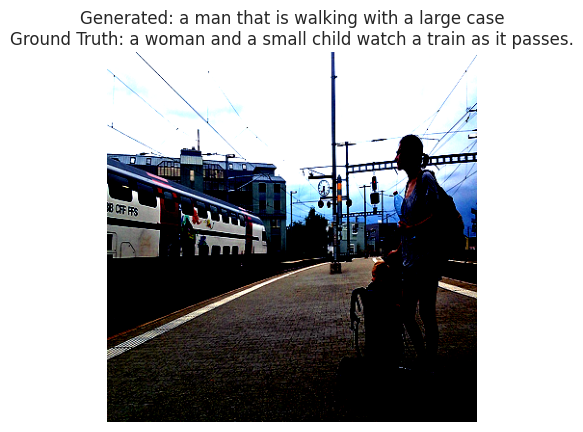

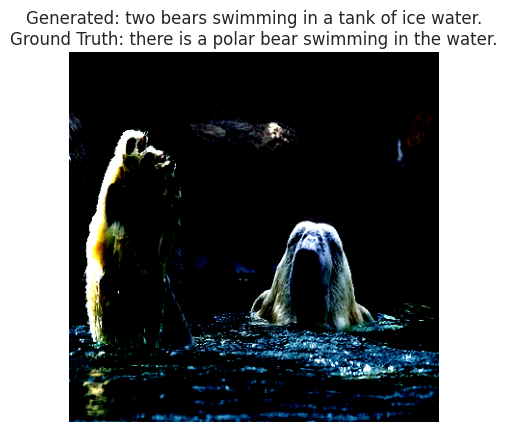

In [ ]:
visualize_captions(images.cpu(), generated_captions, ground_truth_captions, num_samples=5)


##학습되지 않은 데이터셋(test)에도 적합한 캡션이 생기는지 확인

In [ ]:
import gradio as gr

# Load fine-tuned model weights
try:
    model.load_state_dict(torch.load(blip_weights_path, map_location=device))
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
model.eval()

def gradio_caption(image):
    try:
        caption = generate_caption(model, processor, image)
        print(f"Generated caption: {caption}")
        return caption
    except Exception as e:
        # Capture and print the error traceback
        error_message = traceback.format_exc()
        return f"Error occurred: {str(e)}"

# Initialize Gradio interface
iface = gr.Interface(fn=gradio_caption,
                     inputs=gr.Image(type="pil"),
                     outputs="text",
                     title="Blip Image Captioning")

# Launch the interface
iface.launch(debug=False)

<ipython-input-74-fa08868c457e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(blip_weights_path, map_location=device))


Model loaded successfully.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3ec48e06148b3d25a2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
